In [6]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from tabulate import tabulate
import seaborn as sns

In [39]:
def noise_func(noise_term):
    # this function multiplies the noise term with a number between -1 and 1
    return noise_term * ((np.random.rand() * 2) - 1)

def step(X, Y, Z, beta, gamma, mu_b, mu_d, t, noise = (0,0,0,0)):
    noise_b, noise_g, noise_mb, noise_md = noise
    N = X + Y + Z

    # setting the consequences of each event
    event_list = [[1, 0, 0],
                  [-1, 1, 0],
                  [0, -1, 1],
                  [-1, 0, 0],
                  [0, -1, 0],
                  [0, 0, -1]]

    # setting the rate of each event
    R_B = (mu_b + noise_func(noise_mb)) * N
    R_I = (beta + noise_func(noise_b)) * X * Y / N
    R_R = (gamma + noise_func(noise_g)) * Y
    R_DX = (mu_d + noise_func(noise_md)) * X
    R_DY= (mu_d + noise_func(noise_md)) * Y
    R_DZ = (mu_d + noise_func(noise_md)) * Z

    rate_list = [R_B, R_I, R_R, R_DX, R_DY, R_DZ]

    # finding the event which happens first
    dt_min = -1/rate_list[0] * np.log(np.random.rand())
    p = 0
    for m in range(1, len(rate_list)):
        if rate_list[m] > 0:
            dt = -1/rate_list[m] * np.log(np.random.rand())

            if dt < dt_min:
                dt_min = dt
                p = m

    # updating values
    t += dt
    X += event_list[p][0]
    Y += event_list[p][1]
    Z += event_list[p][2]

    return t, X, Y, Z

# parameters
X = 1000
Y = 100
Z = 0
beta = 3
gamma = 1
mu_b = 1/60
mu_d = 1/60
t = 0
noise_b = 0
noise_g = 0
noise_mb = 0
noise_md = 0
noise = (noise_b, noise_g, noise_mb, noise_md)

t_list, X_list, Y_list, Z_list = [], [], [], []
while t < 1000:
    t, X, Y, Z = step(X, Y, Z, beta, gamma, mu_b, mu_d, t, noise)

    t_list.append(t)
    X_list.append(X)
    Y_list.append(Y)
    Z_list.append(Z)

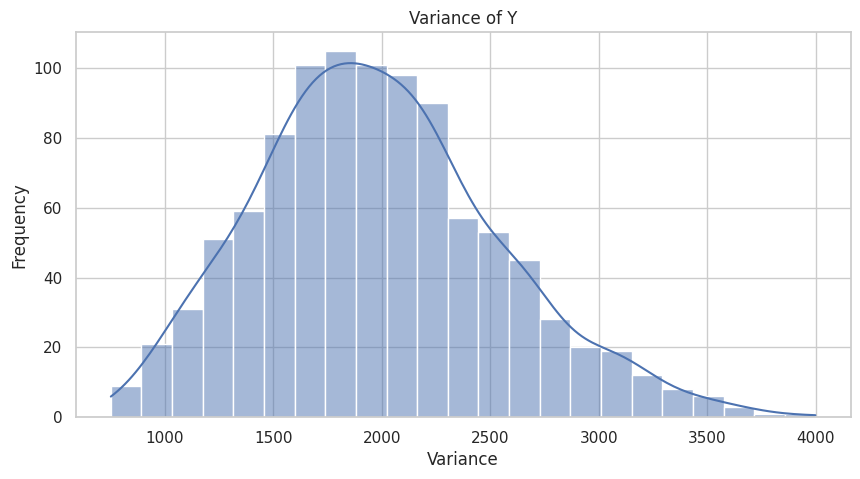

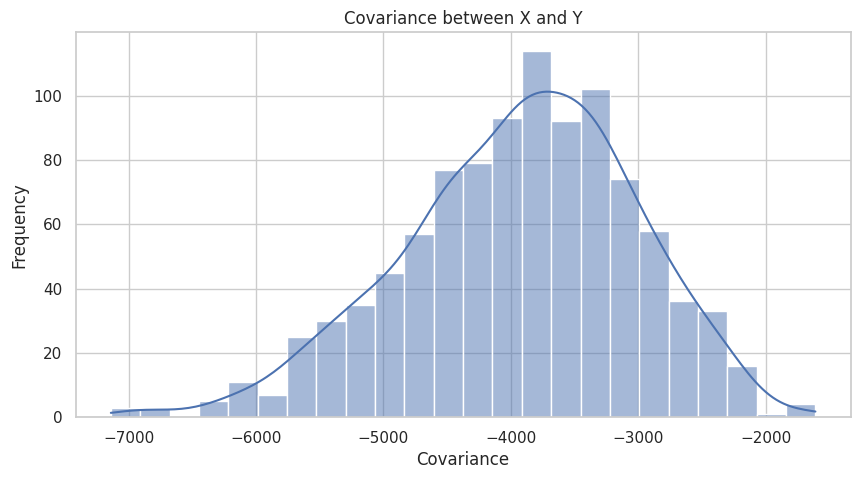

In [40]:
"""
Exercise 1

Simulation Variability and Negative Co-variance
"""

def var(data):
    # Used formula for population since we know all data and thus are not dealing w/ a sample
    length_data = len(data)
    mean_data = np.mean(data)
    var_data = 0

    for i in data:
        var_data += (i - mean_data) ** 2

    return var_data / length_data

def covar(data1, data2):
    length_data = len(data1)
    mean_data1 = np.mean(data1)
    mean_data2 = np.mean(data2)
    var_data = 0

    for i in range(length_data):
        var_data += (data1[i] - mean_data1) * (data2[i] - mean_data2)

    return var_data / length_data

def run(n_average, t_max, X0, Y0, Z0, beta, gamma, mu_b, mu_d, noise=(0,0,0,0)):
    var_list, covar_list = [], []
    for _ in range(n_average):
        t_list, X_list, Y_list, Z_list = [], [], [], []
        t = 0
        X = X0
        Y = Y0
        Z = Z0
        while t < t_max:
            t, X, Y, Z = step(X, Y, Z, beta, gamma, mu_b, mu_d, t, noise)

            t_list.append(t)
            X_list.append(X)
            Y_list.append(Y)
            Z_list.append(Z)

        var_list.append(var(Y_list))
        covar_list.append(covar(X_list, Y_list))

    return var_list, covar_list, t_list

n_average = 1000
t_max = 300

var_list, covar_list,t_list = run(n_average, t_max, X, Y, Z, beta, gamma, mu_b, mu_d, noise)     

sns.set(style="whitegrid", context="notebook")

# Plot variance
plt.figure(figsize=(10, 5))
sns.histplot(var_list, kde=True)
plt.title('Variance of Y')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

# Plot covariance
plt.figure(figsize=(10, 5))
sns.histplot(covar_list, kde=True)
plt.title('Covariance between X and Y')
plt.xlabel('Covariance')
plt.ylabel('Frequency')
plt.show()

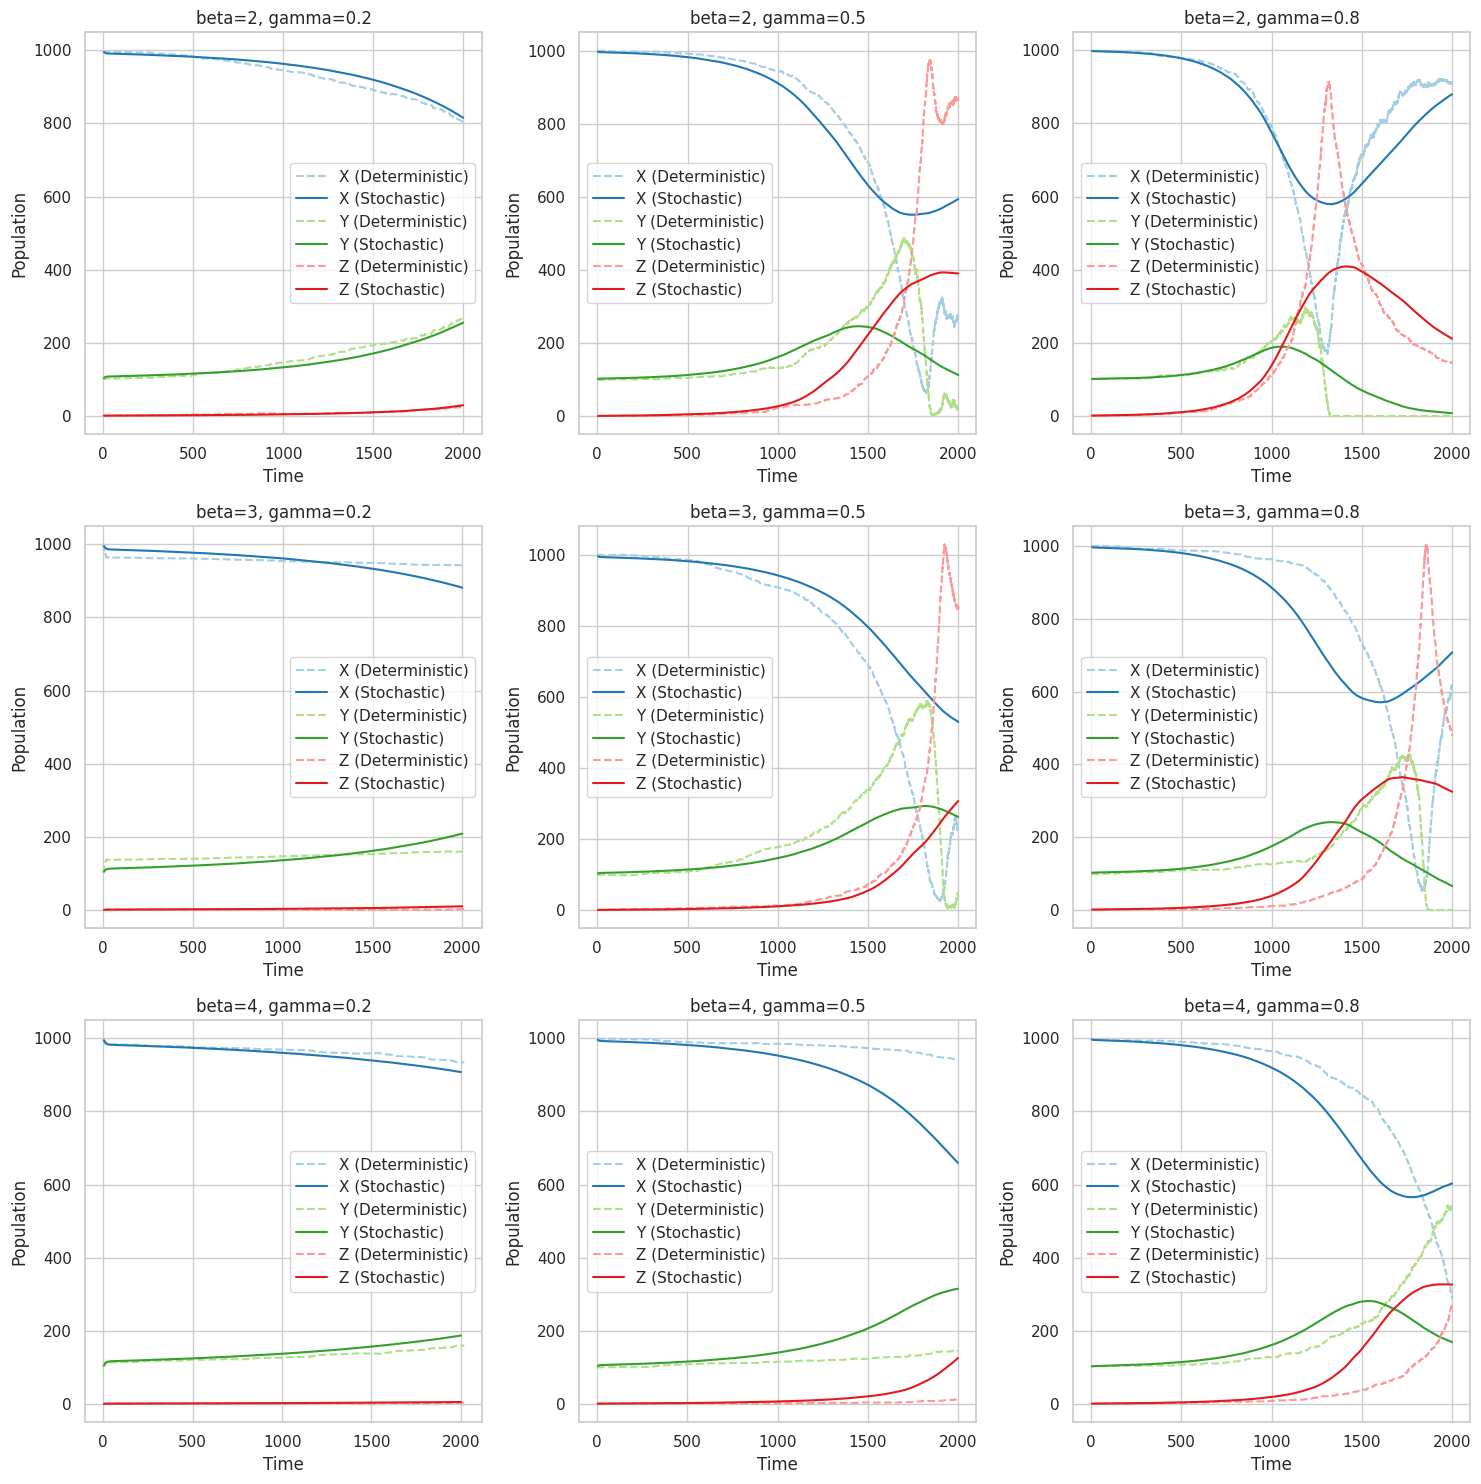

In [47]:
"""
Comparison of model parameters
"""

# function to interpolaste stochastic data for alignment
def interpolate_stochastic_data(t_list, data_list, common_time):
    interpolated_data = np.interp(common_time, t_list, data_list, left=np.nan, right=np.nan)
    return interpolated_data

def simulate_and_plot(beta, gamma, mu_b, mu_d, noise, max_time=2000, num_simulations=1000):
    common_time = np.arange(max_time + 1)
    X_list_combined = np.zeros(common_time.shape)
    Y_list_combined = np.zeros(common_time.shape)
    Z_list_combined = np.zeros(common_time.shape)

    for i in range(num_simulations):
        t_list, X_list, Y_list, Z_list = [], [], [], []

        X = 1000
        Y = 100
        Z = 0
        t = 0

        while t < max_time:
            t, X, Y, Z = step(X, Y, Z, beta, gamma, mu_b, mu_d, t, noise)
            t_list.append(round(t))
            X_list.append(round(X))
            Y_list.append(round(Y))
            Z_list.append(round(Z))

        # store aligned data
        X_list_combined += interpolate_stochastic_data(t_list, X_list, common_time)
        Y_list_combined += interpolate_stochastic_data(t_list, Y_list, common_time)
        Z_list_combined += interpolate_stochastic_data(t_list, Z_list, common_time)

    # average of interpolated data
    X_list_combined /= num_simulations
    Y_list_combined /= num_simulations
    Z_list_combined /= num_simulations

    return common_time, X_list_combined, Y_list_combined, Z_list_combined


def deterministic_simulation(beta, gamma, mu_b, mu_d, max_time=2000):
    t_list, X_list, Y_list, Z_list = [], [], [], []

    X = 1000
    Y = 100
    Z = 0
    t = 0

    while t < max_time:
        t, X, Y, Z = step(X, Y, Z, beta, gamma, mu_b, mu_d, t, noise=(0, 0, 0, 0))
        t_list.append(round(t))
        X_list.append(round(X))
        Y_list.append(round(Y))
        Z_list.append(round(Z))

    return t_list, X_list, Y_list, Z_list

# set up the parameters for comparison
beta_values = [2, 3, 4]
gamma_values = [0.2, 0.5, 0.8]
mu_b = 1/60
mu_d = 1/60
max_time = 2000
num_simulations = 1000

sns.set(style="whitegrid", context="notebook", palette="Paired")
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        common_time, X_list, Y_list, Z_list = simulate_and_plot(beta, gamma, mu_b, mu_d, noise=(0, 0, 0, 0), max_time=max_time, num_simulations=num_simulations)
        t_d, X_d, Y_d, Z_d = deterministic_simulation(beta, gamma, mu_b, mu_d, max_time=max_time)

        axes[i, j].plot(t_d, X_d, label='X (Deterministic)', linestyle='dashed')
        axes[i, j].plot(common_time, X_list, label='X (Stochastic)')
        axes[i, j].plot(t_d, Y_d, label='Y (Deterministic)', linestyle='dashed')
        axes[i, j].plot(common_time, Y_list, label='Y (Stochastic)')
        axes[i, j].plot(t_d, Z_d, label='Z (Deterministic)', linestyle='dashed')
        axes[i, j].plot(common_time, Z_list, label='Z (Stochastic)')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('Population')
        axes[i, j].set_title(f'beta={beta}, gamma={gamma}')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

0 0 0 0.1 2.0 0.2
0 0 1 0.1 2.0 0.2666666666666667
0 0 2 0.1 2.0 0.33333333333333337
0 0 3 0.1 2.0 0.4
0 0 4 0.1 2.0 0.46666666666666673
0 0 5 0.1 2.0 0.5333333333333334
0 0 6 0.1 2.0 0.6000000000000001
0 0 7 0.1 2.0 0.6666666666666667
0 0 8 0.1 2.0 0.7333333333333334
0 0 9 0.1 2.0 0.8
0 1 0 0.1 2.2222222222222223 0.2
0 1 1 0.1 2.2222222222222223 0.2666666666666667
0 1 2 0.1 2.2222222222222223 0.33333333333333337
0 1 3 0.1 2.2222222222222223 0.4
0 1 4 0.1 2.2222222222222223 0.46666666666666673
0 1 5 0.1 2.2222222222222223 0.5333333333333334
0 1 6 0.1 2.2222222222222223 0.6000000000000001
0 1 7 0.1 2.2222222222222223 0.6666666666666667
0 1 8 0.1 2.2222222222222223 0.7333333333333334
0 1 9 0.1 2.2222222222222223 0.8
0 2 0 0.1 2.4444444444444446 0.2
0 2 1 0.1 2.4444444444444446 0.2666666666666667
0 2 2 0.1 2.4444444444444446 0.33333333333333337
0 2 3 0.1 2.4444444444444446 0.4
0 2 4 0.1 2.4444444444444446 0.46666666666666673
0 2 5 0.1 2.4444444444444446 0.5333333333333334
0 2 6 0.1 2.4444

2 0 5 0.5 2.0 0.5333333333333334
2 0 6 0.5 2.0 0.6000000000000001
2 0 7 0.5 2.0 0.6666666666666667
2 0 8 0.5 2.0 0.7333333333333334
2 0 9 0.5 2.0 0.8
2 1 0 0.5 2.2222222222222223 0.2
2 1 1 0.5 2.2222222222222223 0.2666666666666667
2 1 2 0.5 2.2222222222222223 0.33333333333333337
2 1 3 0.5 2.2222222222222223 0.4
2 1 4 0.5 2.2222222222222223 0.46666666666666673
2 1 5 0.5 2.2222222222222223 0.5333333333333334
2 1 6 0.5 2.2222222222222223 0.6000000000000001
2 1 7 0.5 2.2222222222222223 0.6666666666666667
2 1 8 0.5 2.2222222222222223 0.7333333333333334
2 1 9 0.5 2.2222222222222223 0.8
2 2 0 0.5 2.4444444444444446 0.2
2 2 1 0.5 2.4444444444444446 0.2666666666666667
2 2 2 0.5 2.4444444444444446 0.33333333333333337
2 2 3 0.5 2.4444444444444446 0.4
2 2 4 0.5 2.4444444444444446 0.46666666666666673
2 2 5 0.5 2.4444444444444446 0.5333333333333334
2 2 6 0.5 2.4444444444444446 0.6000000000000001
2 2 7 0.5 2.4444444444444446 0.6666666666666667
2 2 8 0.5 2.4444444444444446 0.7333333333333334
2 2 9 0.5

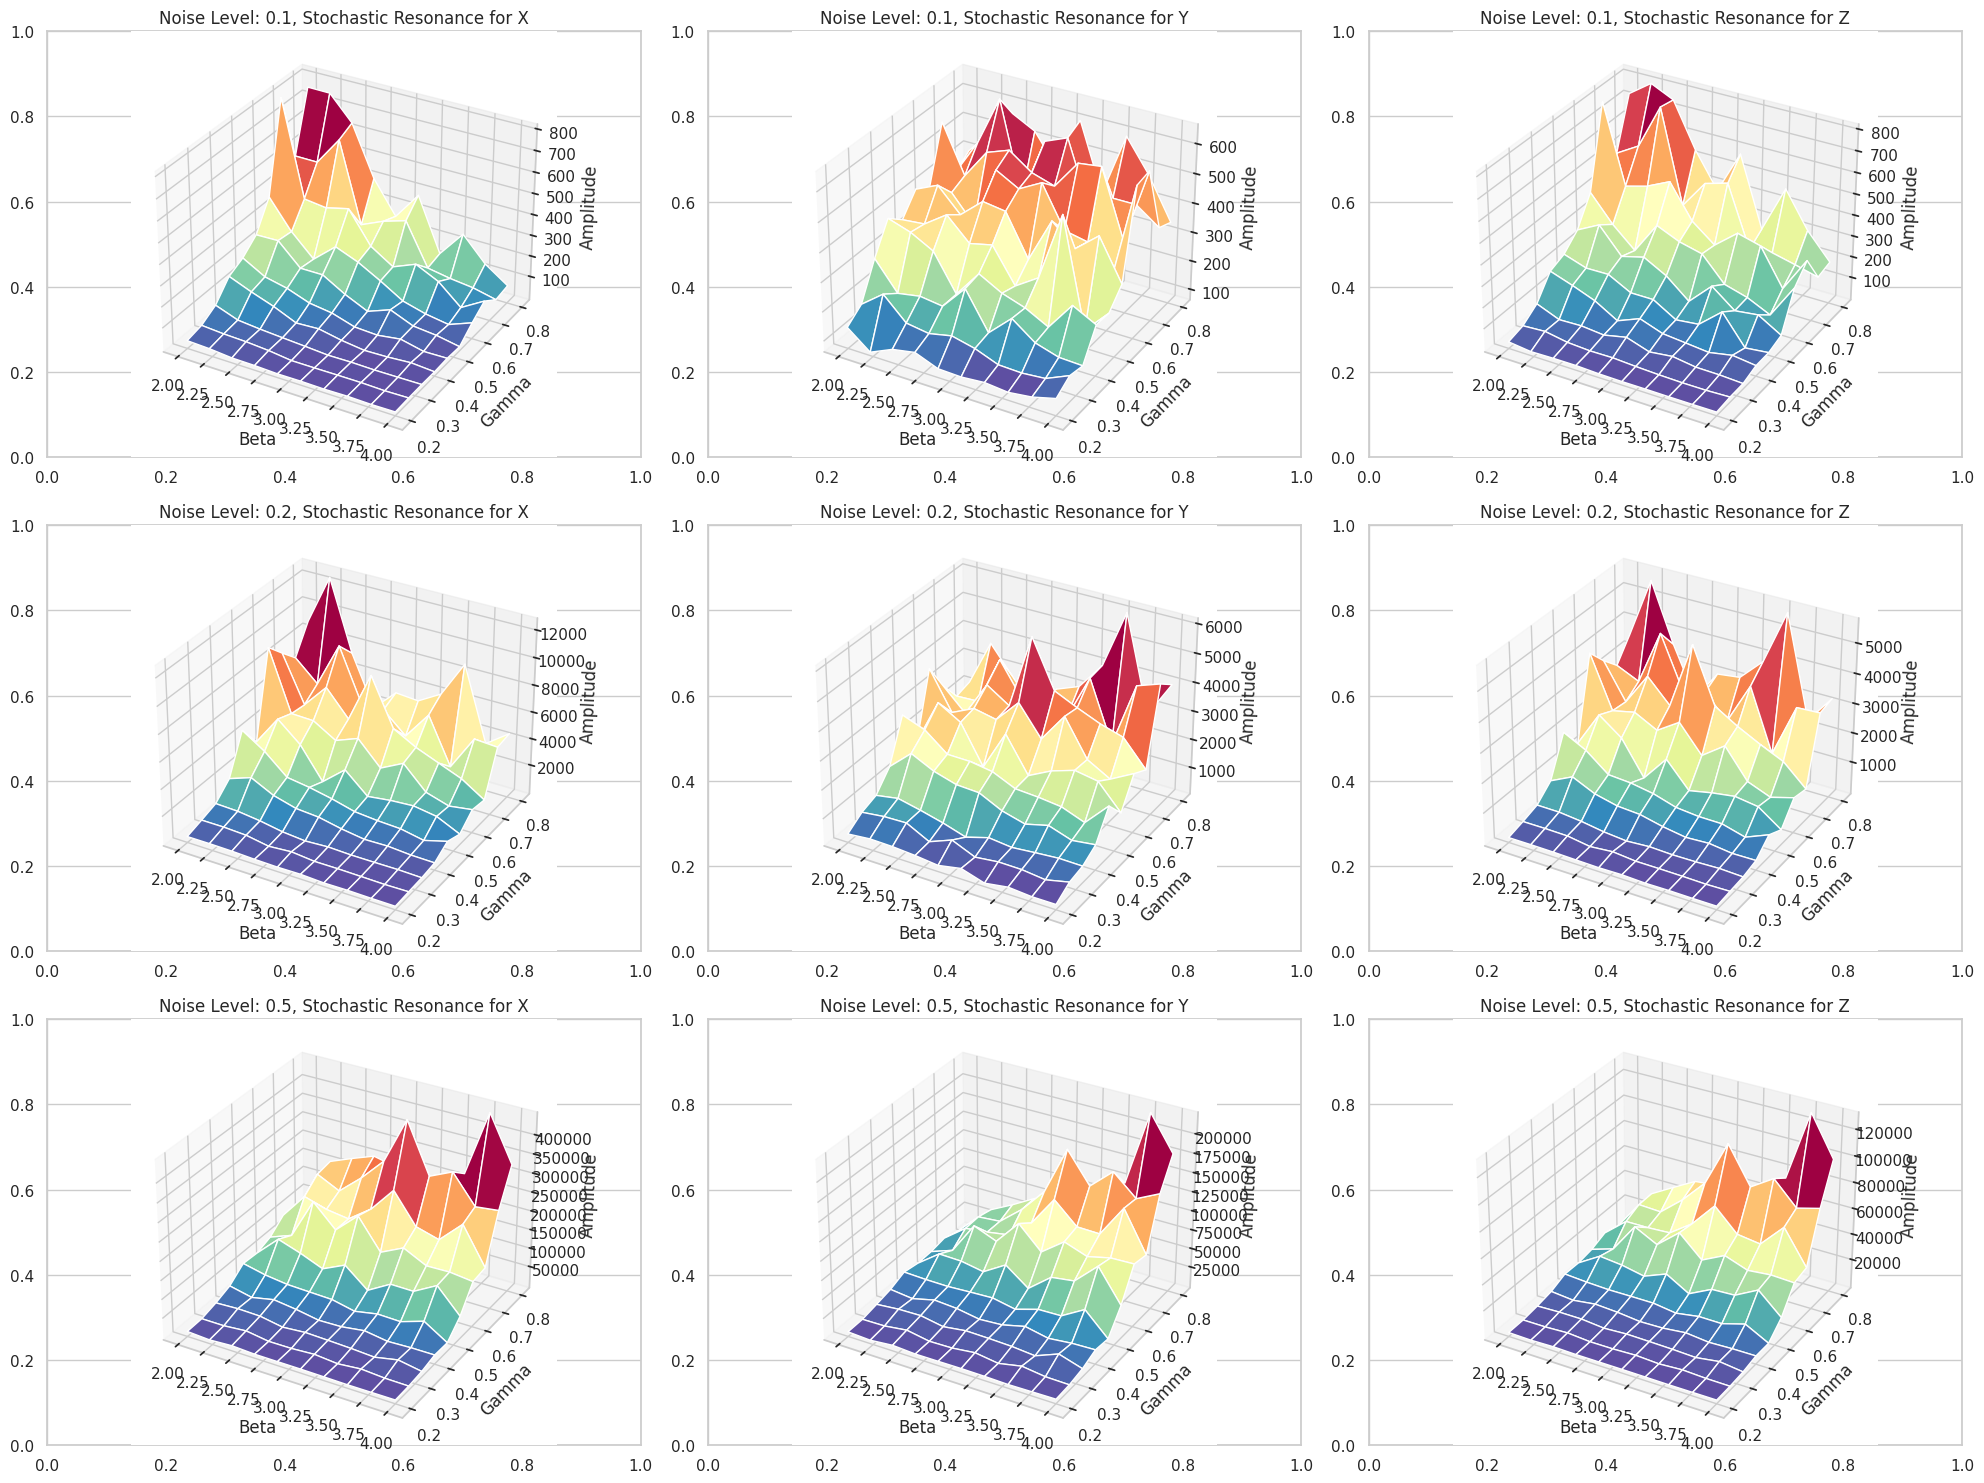

In [ ]:
"""
Stochastic resonance
"""

num_simulations = 25

# set parameters for the surface experiment
beta_values = np.linspace(2, 4, 10)
gamma_values = np.linspace(0.2, 0.8, 10)
noise_levels = [0.1, 0.2, 0.5]

# empty arrays to store data
amplitude_results_X = np.zeros((len(noise_levels), len(beta_values), len(gamma_values)))
amplitude_results_Y = np.zeros((len(noise_levels), len(beta_values), len(gamma_values)))
amplitude_results_Z = np.zeros((len(noise_levels), len(beta_values), len(gamma_values)))

# loop over 3 parameters
for k, noise_level in enumerate(noise_levels):
    for i, beta in enumerate(beta_values):
        for j, gamma in enumerate(gamma_values):
            _, X_list, Y_list, Z_list = simulate_and_plot(beta, gamma, mu_b, mu_d, noise=(noise_level, noise_level, noise_level, noise_level), max_time=max_time, num_simulations=num_simulations)
            X_list = X_list[~np.isnan(X_list)]
            Y_list = Y_list[~np.isnan(Y_list)]
            Z_list = Z_list[~np.isnan(Z_list)]
            print(k, i, j, noise_level, beta, gamma)

            ## amplitudes
            amplitude_results_X[k, i, j] = np.max(X_list) - np.min(X_list)
            amplitude_results_Y[k, i, j] = np.max(Y_list) - np.min(Y_list)
            amplitude_results_Z[k, i, j] = np.max(Z_list) - np.min(Z_list)


fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for k, noise_level in enumerate(noise_levels):
    for row, var_name in enumerate(["X", "Y", "Z"]):
        ax = fig.add_subplot(3, 3, k * 3 + row + 1, projection = '3d')
        ax.set_title(f'Noise Level: {noise_level}, Stochastic Resonance for {var_name}')
        beta_mesh, gamma_mesh = np.meshgrid(beta_values, gamma_values)
        if var_name == "X":
            amplitude_results = amplitude_results_X[k]
        elif var_name == "Y":
            amplitude_results = amplitude_results_Y[k]
        else:
            amplitude_results = amplitude_results_Z[k]
        surf = ax.plot_surface(beta_mesh, gamma_mesh, amplitude_results.T, cmap='Spectral_r')
        ax.set_xlabel('Beta')
        ax.set_ylabel('Gamma')
        ax.set_zlabel('Amplitude')

plt.tight_layout()
plt.show()


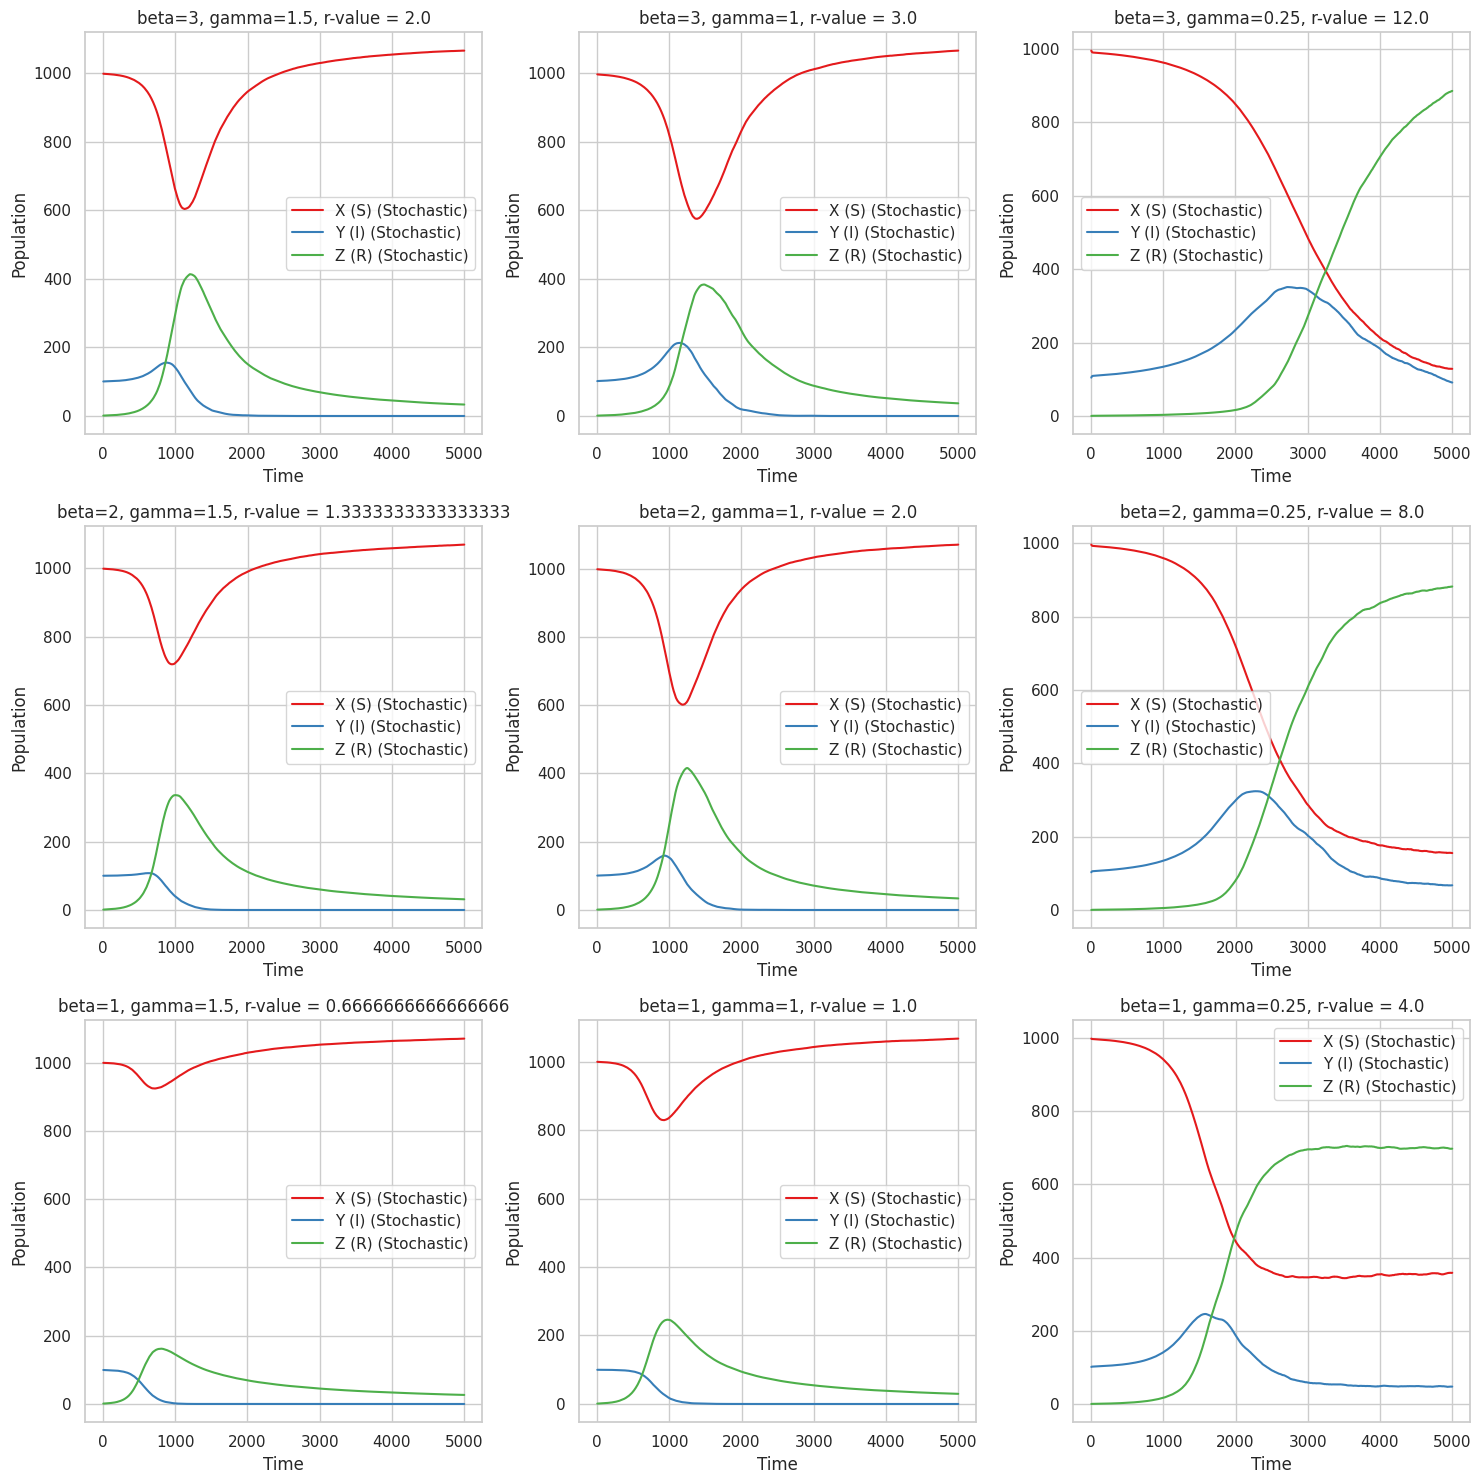

In [48]:
""" 
Extinction part 1
"""
beta_values = [3, 2, 1]
gamma_values = [1.5, 1, 0.25]
mu_b = 1/60
mu_d = 1/60
# increase time steps
max_time = 5000
num_simulations = 1000

sns.set(style="whitegrid", context="notebook", palette='Set1')
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# loop over beta and gamma values to try R0 combinations
for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        common_time, X_list, Y_list, Z_list = simulate_and_plot(beta, gamma, mu_b, mu_d, noise=(0, 0, 0, 0), max_time=max_time, num_simulations=num_simulations)

        axes[i, j].plot(common_time, X_list, label='X (S) (Stochastic)')
        axes[i, j].plot(common_time, Y_list, label='Y (I) (Stochastic)')
        axes[i, j].plot(common_time, Z_list, label='Z (R) (Stochastic)')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('Population')
        axes[i, j].set_title(f'beta={beta}, gamma={gamma}, r-value = {beta/gamma}')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

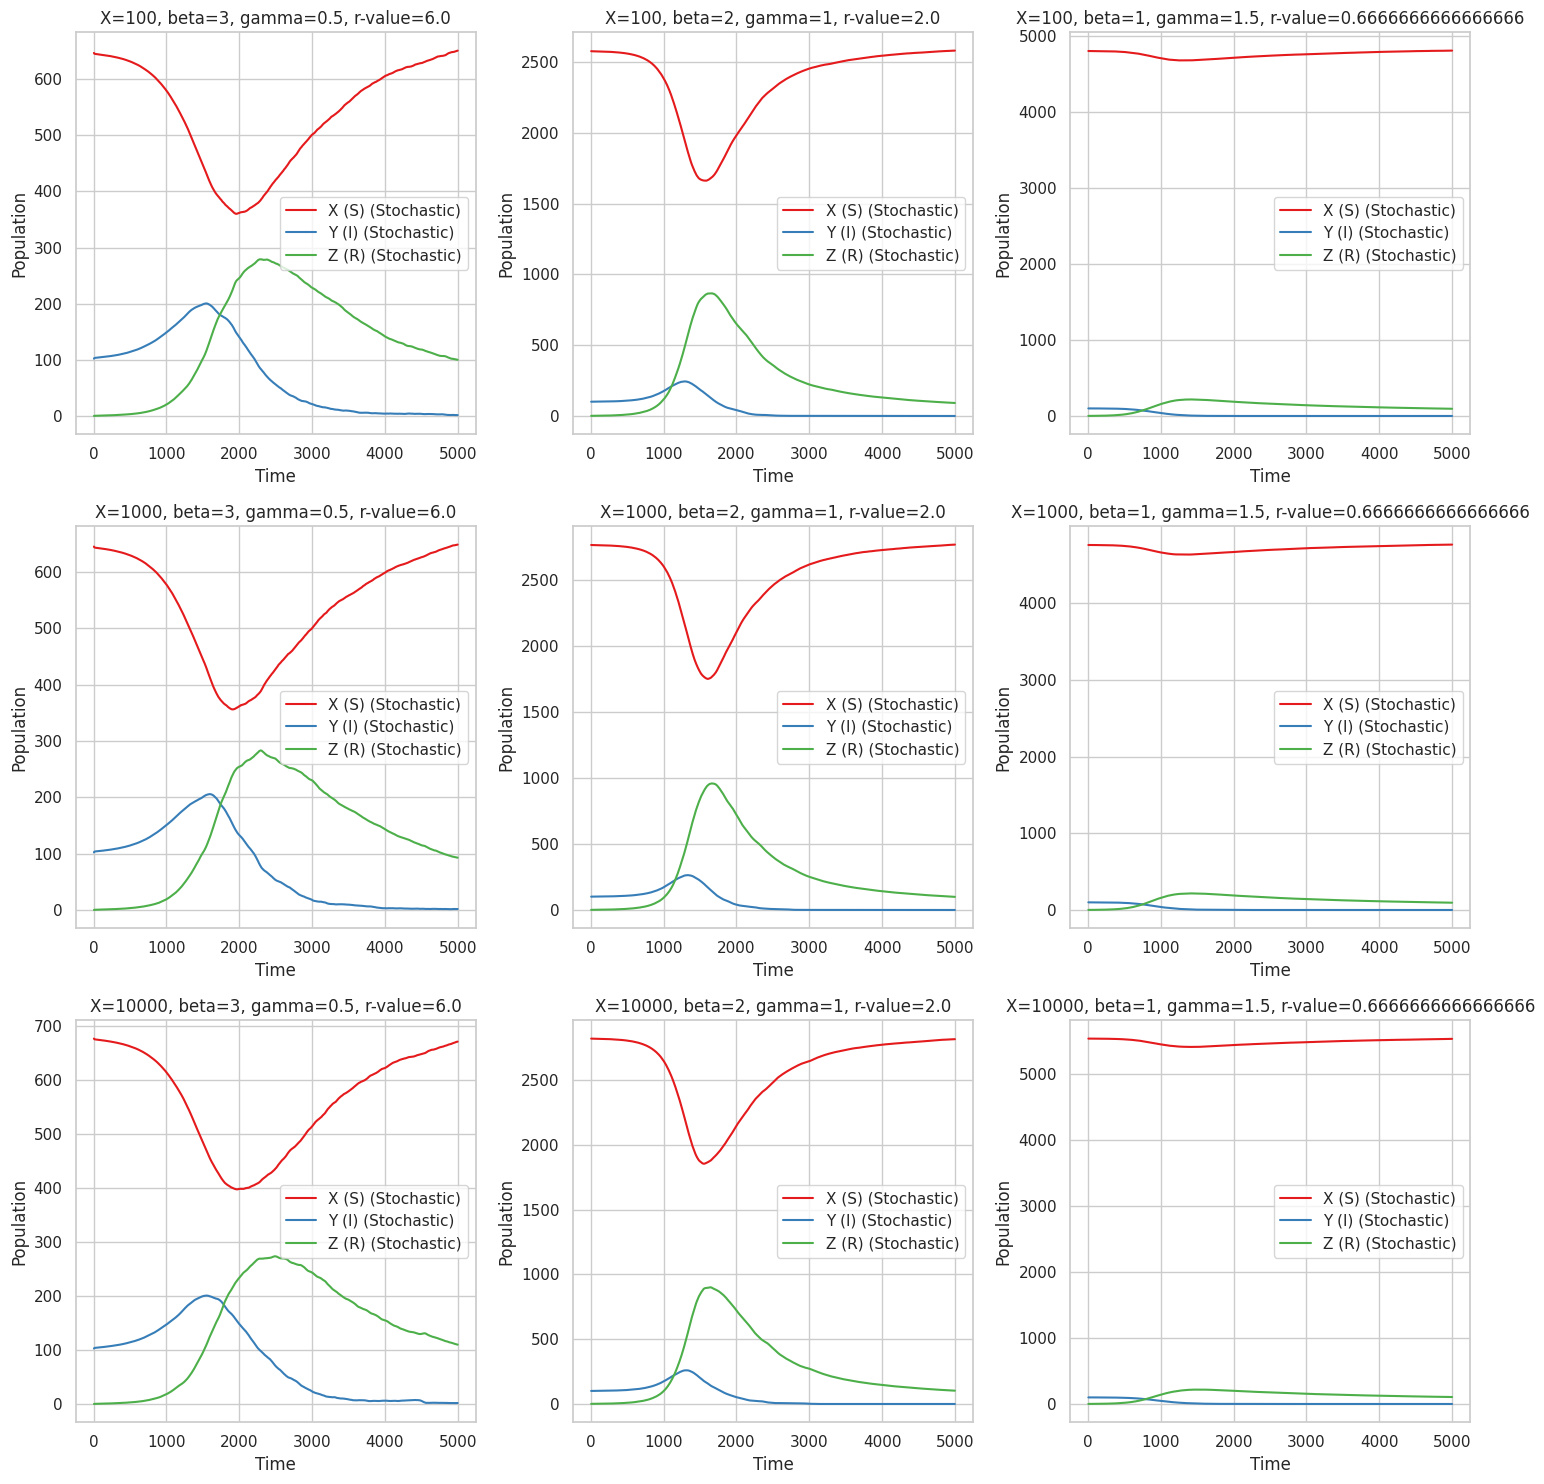

In [49]:
""" 
Extinction part 2
"""
# slightyl changed function to include X parameter 
def simulate_and_plot(beta, gamma, mu_b, mu_d, noise, X, max_time=2000, num_simulations=1000, r_values=None):
    common_time = np.arange(max_time + 1)
    X_list_combined = np.zeros(common_time.shape)
    Y_list_combined = np.zeros(common_time.shape)
    Z_list_combined = np.zeros(common_time.shape)

    for i in range(num_simulations):
        t_list, X_list, Y_list, Z_list = [], [], [], []

        # X is removed here
        Y = 100
        Z = 0
        t = 0

        while t < max_time:
            t, X, Y, Z = step(X, Y, Z, beta, gamma, mu_b, mu_d, t, noise)
            t_list.append(round(t))
            X_list.append(round(X))
            Y_list.append(round(Y))
            Z_list.append(round(Z))

        X_list_combined += interpolate_stochastic_data(t_list, X_list, common_time)
        Y_list_combined += interpolate_stochastic_data(t_list, Y_list, common_time)
        Z_list_combined += interpolate_stochastic_data(t_list, Z_list, common_time)

    X_list_combined /= num_simulations
    Y_list_combined /= num_simulations
    Z_list_combined /= num_simulations

    return common_time, X_list_combined, Y_list_combined, Z_list_combined

mu_b = 1/60
mu_d = 1/60
max_time = 5000
num_simulations = 1000
# r values now as pairs of beta and gamma
r_values = [(3, 0.5), (2, 1), (1, 1.5)]  
# X values to insert into modified simulate_and_plot function
X_values = [100, 1000, 10000]

sns.set(style="whitegrid", context="notebook", palette='Set1')
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, X in enumerate(X_values):
    for j, r in enumerate(r_values):
        beta, gamma = r
        common_time, X_list, Y_list, Z_list = simulate_and_plot(beta, gamma, mu_b, mu_d, noise=(0, 0, 0, 0), X=X, max_time=max_time, num_simulations=num_simulations)

        axes[i, j].plot(common_time, X_list, label='X (S) (Stochastic)')
        axes[i, j].plot(common_time, Y_list, label='Y (I) (Stochastic)')
        axes[i, j].plot(common_time, Z_list, label='Z (R) (Stochastic)')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('Population')
        axes[i, j].set_title(f'X={X}, beta={beta}, gamma={gamma}, r-value={beta/gamma}')
        axes[i, j].legend()

plt.tight_layout()
plt.show()


In [2]:
def give_mean(data):
    return np.mean(list(data.values()))

def give_properties(G):
    clustering_coefficient = give_mean(nx.clustering(G, nodes=None, weight=None))
    closeness_centrality = give_mean(nx.closeness_centrality(G, u=None, distance=None, wf_improved=True))
    betweenness_centrality = give_mean(nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None))
    degree_centrality = give_mean(nx.degree_centrality(G))

    properties = np.matrix([clustering_coefficient, closeness_centrality, betweenness_centrality, degree_centrality])

    return(properties)

def evaluate(beta, gamma, I, n_iterations, G):
    """
    This function evaluates the spread of disease following the SIR model using the NDlib package 
    (https://ndlib.readthedocs.io/en/latest/index.html). It first implements the SIR model on the given network G. Next,
    the model parameters beta, gamma, and the number of initial infections is set for the model. The returned dictionairy trends gives the 
    amount of nodes in each state and the rate of change for each state. 
    """
    model = ep.SIRModel(G)

    # Setting model parameters
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter("fraction_infected", I)

    model.set_initial_status(cfg)

    # Running the simulation
    iterations = model.iteration_bunch(n_iterations)
    trends = model.build_trends(iterations)

    return trends

In [3]:
# Generate Networks of equivalent Form
p = 0.1
runs=1000

def give_networks(n):
    k = int(p*n)
    m = int(k/2)

    properties_er, properties_ws, properties_ba = np.zeros((4,runs)), np.zeros((4,runs)), np.zeros((4,runs))
    er_list, ws_list, ba_list = [], [], []

    for i in range(0, runs):
        seed=int(i)
        er = nx.erdos_renyi_graph(n, p, seed)   
        properties_er[:,i] = give_properties(er)
        er_list.append(er)
        
    for i in range(0, runs):
        seed=int(i)
        ws = nx.watts_strogatz_graph(n, k, p, seed)
        properties_ws[:,i] = give_properties(ws)
        ws_list.append(ws)

    for i in range(0, runs):
        seed=int(i)
        ba = nx.barabasi_albert_graph(n, m, seed)
        properties_ba[:,i] = give_properties(ba)
        ba_list.append(ba)

    table_sd = [['barabasi-albert', 3*np.std(properties_ba[0,:])/np.sqrt(runs), 3*np.std(properties_ba[1,:])/np.sqrt(runs), 3*np.std(properties_ba[2,:])/np.sqrt(runs), 3*np.std(properties_ba[3,:]/np.sqrt(runs))],
            ['watts-strogatz', 3*np.std(properties_ws[0,:])/np.sqrt(runs), 3*np.std(properties_ws[1,:])/np.sqrt(runs), 3*np.std(properties_ws[2,:])/np.sqrt(runs), 3*np.std(properties_ws[3,:]/np.sqrt(runs))], 
            ['erdos-renyi', 3*np.std(properties_er[0,:])/np.sqrt(runs), 3*np.std(properties_er[1,:])/np.sqrt(runs), 3*np.std(properties_er[2,:])/np.sqrt(runs), 3*np.std(properties_er[3,:])/np.sqrt(runs)]]

    table = [['barabasi-albert', np.mean(properties_ba[0,:]), np.mean(properties_ba[1,:]), np.mean(properties_ba[2,:]), np.mean(properties_ba[3,:])],
            ['watts-strogatz', np.mean(properties_ws[0,:]), np.mean(properties_ws[1,:]), np.mean(properties_ws[2,:]), np.mean(properties_ws[3,:])], 
            ['erdos-renyi', np.mean(properties_er[0,:]), np.mean(properties_er[1,:]), np.mean(properties_er[2,:]), np.mean(properties_er[3,:])]]

    print(f'\n 3\u03C3 for n={n} nodes')
    print(tabulate(table_sd, headers=['clustering_coefficient', 'closeness_centrality', 'betweenness_centrality', 'degree_centrality']))

    print(f'\n properties for n={n} nodes')
    print(tabulate(table, headers=['clustering_coefficient', 'closeness_centrality', 'betweenness_centrality', 'degree_centrality']))

    return (er_list, ws_list, ba_list)

er_list_50, ws_list_50, ba_list_50 = give_networks(50)
er_list, ws_list, ba_list = give_networks(100) ### Saving for next experiment
er_list_200, ws_list_200, ba_list_200 = give_networks(200)


 3σ for n=50 nodes
                   clustering_coefficient    closeness_centrality    betweenness_centrality    degree_centrality
---------------  ------------------------  ----------------------  ------------------------  -------------------
barabasi-albert                0.00591397              0.00104993               0.000148509          2.53219e-18
watts-strogatz                 0.00382742              0.00202554               0.000714431          1.9507e-18
erdos-renyi                    0.00261897              0.00189967               0.000242409          0.000786405

 3σ for n=100 nodes
                   clustering_coefficient    closeness_centrality    betweenness_centrality    degree_centrality
---------------  ------------------------  ----------------------  ------------------------  -------------------
barabasi-albert               0.00191607              0.000327471               1.60863e-05          2.30362e-18
watts-strogatz                0.00204308              0.

In [16]:
# Simulate SIR spread on the network
plt.clf()
beta_list =  [1, 1/3, 1/6] 
gamma = 1/3
I0 = 0.01
n_iterations = 30
n_samples=100

for beta in beta_list:
    # First create empty lists to store values for X, Y and Z
    er_X, er_Y, er_Z = [0]*n_iterations, [0]*n_iterations, [0]*n_iterations
    ws_X, ws_Y, ws_Z = [0]*n_iterations, [0]*n_iterations, [0]*n_iterations
    ba_X, ba_Y, ba_Z = [0]*n_iterations, [0]*n_iterations, [0]*n_iterations

    for i in range(n_samples):
        er = er_list[i]
        ws = ws_list[i]
        ba = ba_list[i]

        trends_er = evaluate(beta, gamma, I0, n_iterations, er)
        trends_ws = evaluate(beta, gamma, I0, n_iterations, ws)
        trends_ba = evaluate(beta, gamma, I0, n_iterations, ba)

        # Add values of i-th evaluation to the matrix
        er_X = np.add(er_X, trends_er[0]['trends']['node_count'][0])
        er_Y = np.add(er_Y, trends_er[0]['trends']['node_count'][1])
        er_Z = np.add(er_Z, trends_er[0]['trends']['node_count'][2])

        ws_X = np.add(ws_X, trends_ws[0]['trends']['node_count'][0]) 
        ws_Y = np.add(ws_Y, trends_ws[0]['trends']['node_count'][1]) 
        ws_Z = np.add(ws_Z, trends_ws[0]['trends']['node_count'][2]) 

        ba_X = np.add(ba_X, trends_ba[0]['trends']['node_count'][0]) 
        ba_Y = np.add(ba_Y, trends_ba[0]['trends']['node_count'][1]) 
        ba_Z = np.add(ba_Z, trends_ba[0]['trends']['node_count'][2]) 

    # Normalize number of hosts by deviding by number of samples and number of nodes (100)
    er_I = er_Y/(100*n_samples)
    ws_I = ws_Y/(100*n_samples)
    ba_I = ba_Y/(100*n_samples)

    plt.figure(figsize=(10,6), tight_layout=True)
    plt.ylim(0,1)

    
    plt.plot(er_I, label="Erd\u0151s-R\u00e9nyi", linewidth=2)
    plt.plot(ws_I, label="Watts-Strogatz", linewidth=2)
    plt.plot(ba_I, label="Barab\u00e1si-Albert", linewidth=2)
    plt.legend()

    plt.xlabel('t', fontsize = 25)
    plt.ylabel('I', fontsize = 25)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.title(f'Fraction of infected hosts over time', fontsize=25)
    plt.legend(fontsize = 24)
    plt.grid()

    plt.savefig(f'plots2/beta-{np.round(beta,2)}_gamma-{np.round(gamma,2)}_I0-{I0}.png')

    plt.clf()

In [17]:
# Dynamic vaccination campaign

def evaluate_vacc_step(beta, gamma, infected_nodes, n_iterations, G, test_accuracy=1, tests_used=0, n_vacc=0, test_max=200):
    model = ep.SIRModel(G) 

    # Test if there are infected nodes and if there are any tests left to use
    if len(infected_nodes) != 0 and tests_used < test_max:
        for _ in range(n_vacc):
            # Look for nodes with highest closeness centrality
            closeness_centrality = nx.closeness_centrality(G)
            closeness_centrality_values = list(closeness_centrality.values())
            closeness_centrality_ordered = sorted(list(closeness_centrality.values()), reverse=True)

            infected = True
            next_max = 0

            # Keep looking for a node to vaccinate until one is found or all nodes have been looked into
            while infected == True and next_max < len(closeness_centrality_ordered):
                accuracy = np.random.binomial(1, test_accuracy)
                target_index = closeness_centrality_values.index(closeness_centrality_ordered[next_max])
                target_node = list(closeness_centrality.keys())[target_index]
                tests_used += 1
                next_max += 1

                # In case of a false negative, the vaccination is "thrown out"
                if target_node in infected_nodes and accuracy == 0:
                    infected = False
                
                # In case a suscpetible is found and not all tests have been used yet, the node is removed from the system
                if target_node not in infected_nodes and accuracy == 1 and tests_used < test_max:
                    G.remove_node(target_node)
                    infected = False
                
    for _ in range(n_iterations):
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        cfg.add_model_initial_configuration("Infected", infected_nodes)

        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(1)
        trends = model.build_trends(iterations)

        # Find direct neighbors of infected nodes
        neighbors_infected_nodes = []
        for node in infected_nodes:
            for neighbor_node in G.neighbors(node):
                neighbors_infected_nodes.append(neighbor_node)

            # Remove neighbor if neighbor already infected
            overlap = np.intersect1d(neighbors_infected_nodes, infected_nodes)
            for node in overlap:
                neighbors_infected_nodes.remove(node)
            
            # Only have each neighbour once, even if it is shared by multiple nodes
            neighbors_infected_nodes = list(np.unique(neighbors_infected_nodes))

        number_of_infections = trends[0]['trends']['status_delta'][1][0]
        
        if number_of_infections > 0:
            """Random neighbors of the infected nodes are now infected, if the simulation asks for more infections than
            there are direct neighbors all direct neighbors will be infected"""
            if len(neighbors_infected_nodes) > number_of_infections:
                added_infections = np.random.choice(neighbors_infected_nodes, number_of_infections, replace=False)
            else:
                added_infections = np.random.choice(neighbors_infected_nodes, len(neighbors_infected_nodes), replace=False)
            
            infected_nodes.extend(added_infections)
        
        if number_of_infections < 0:
            """Random infected nodes are now recovered, if the simulation asks for more recovering infected hosts than
            there are infected hosts all infected hosts will recover"""
            if len(infected_nodes) > np.abs(number_of_infections):
                removed_infections = np.random.choice(infected_nodes, np.abs(number_of_infections), replace=False)
            else:
                removed_infections = np.random.choice(infected_nodes, len(infected_nodes), replace=False)

            for removed_infection in removed_infections:
                infected_nodes.remove(removed_infection)
                G.remove_node(removed_infection)
                recovered_nodes.append(removed_infection)

    return G, infected_nodes, recovered_nodes, tests_used
    

"Creating edgelist"
data = np.loadtxt(open("transmission_network.csv", "rb"), delimiter=";", skiprows=1)[:, 1:]
nonzero_x = np.nonzero(data)[0]
nonzero_y = np.nonzero(data)[1]

edges=[]
for i in range(len(nonzero_x)):
    edges.append((nonzero_x[i], nonzero_y[i]))

"Set parameters"
beta =  1
gamma = 1/3
n_iterations = 2
n_vacc_list = [1,3,5,10]
test_accuracy_list=[0.5,0.75,1]

n_samples=1000
end_time={}
max_infected={}
end_time_std={}
max_infected_std={}

for test_accuracy in test_accuracy_list:
    for n_vacc in n_vacc_list:
        end_time_list, max_infected_list = [], []
        end_time_list_std, max_infected_list_std = [], []
        
        for _ in range(n_samples):
            G = nx.from_edgelist(edges)
            # Randomly select 5 nodes which are infected
            infected_nodes =  list(np.random.choice(list(G.nodes), 5, replace=False))
            tests_used = 0
            max_infected_nodes = 0 
            t = -1 ### Start at t=0
            test_max = 200

            # Run  simulation until there are no infected nodes left
            while len(infected_nodes) != 0:
                t+=1
                G_new, infected_nodes_new, recovered_nodes, tests_used_new = evaluate_vacc_step(beta, gamma, infected_nodes, n_iterations, G, test_accuracy, tests_used, n_vacc, test_max)
                G=G_new
                infected_nodes=infected_nodes
                tests_used = tests_used_new

                if len(infected_nodes) > max_infected_nodes:
                    max_infected_nodes = len(infected_nodes)
                    
            end_time_list.append(t)
            max_infected_list.append(max_infected_nodes)

        end_time[test_accuracy, n_vacc] = np.mean(end_time_list)
        max_infected[test_accuracy, n_vacc] = np.mean(max_infected_list)

        end_time_std[test_accuracy, n_vacc] = np.std(end_time_list) / np.sqrt(n_samples)
        max_infected_std[test_accuracy, n_vacc] = np.mean(max_infected_list) / np.sqrt(n_samples)


In [18]:
### Below a modified version of the code above is given where test_max = n_vacc = 0 and thus no tests or vaccinations will be performed

end_time_value_list = []
max_infected_nodes_list = []
n_samples = 1000

for _ in range(n_samples):
    G = nx.from_edgelist(edges)
    infected_nodes =  list(np.random.choice(list(G.nodes), 5, replace=False))
    tests_used = 0
    t = -1 ### Start at t=0
    test_max = 0
    n_vacc = 0
    max_infected_nodes = 0
    while len(infected_nodes) != 0:
        t+=1
        G_new, infected_nodes_new, recovered_nodes, tests_used_new = evaluate_vacc_step(beta, gamma, infected_nodes, n_iterations, G, test_accuracy, tests_used, n_vacc, test_max)
        G=G_new
        infected_nodes=infected_nodes
        tests_used = tests_used_new

        if len(infected_nodes) > max_infected_nodes:
            max_infected_nodes = len(infected_nodes)

    end_time_value_list.append(t)
    max_infected_nodes_list.append(max_infected_nodes)

print('Average time until the disease passes', np.mean(end_time_value_list), 3*np.std(end_time_value_list)/np.sqrt(n_samples))
print('Average maximum number of infected hosts', np.mean(max_infected_nodes_list), 3*np.std(max_infected_nodes_list)/np.sqrt(n_samples))

Average time until the disease passes 74.065 0.9362344658257353
Average maximum number of infected hosts 267.192 0.6372944562759039


In [19]:
table = [[test_accuracy_list[0], end_time[test_accuracy_list[0], n_vacc_list[0]], end_time[test_accuracy_list[0], n_vacc_list[1]], end_time[test_accuracy_list[0], n_vacc_list[2]], end_time[test_accuracy_list[0], n_vacc_list[3]]],
         [test_accuracy_list[1], end_time[test_accuracy_list[1], n_vacc_list[0]], end_time[test_accuracy_list[1], n_vacc_list[1]], end_time[test_accuracy_list[1], n_vacc_list[2]], end_time[test_accuracy_list[1], n_vacc_list[3]]], 
         [test_accuracy_list[2], end_time[test_accuracy_list[2], n_vacc_list[0]],end_time[test_accuracy_list[2], n_vacc_list[1]], end_time[test_accuracy_list[2], n_vacc_list[2]], end_time[test_accuracy_list[2], n_vacc_list[3]]]]

table_std = [[test_accuracy_list[0], 3*end_time_std[test_accuracy_list[0], n_vacc_list[0]], 3*end_time_std[test_accuracy_list[0], n_vacc_list[1]], 3*end_time_std[test_accuracy_list[0], n_vacc_list[2]], 3*end_time_std[test_accuracy_list[0], n_vacc_list[3]]],
         [test_accuracy_list[1], 3*end_time_std[test_accuracy_list[1], n_vacc_list[0]], 3*end_time_std[test_accuracy_list[1], n_vacc_list[1]], 3*end_time_std[test_accuracy_list[1], n_vacc_list[2]], 3*end_time_std[test_accuracy_list[1], n_vacc_list[3]]], 
         [test_accuracy_list[2], 3*end_time_std[test_accuracy_list[2], n_vacc_list[0]],3*end_time_std[test_accuracy_list[2], n_vacc_list[1]], 3*end_time_std[test_accuracy_list[2], n_vacc_list[2]], 3*end_time_std[test_accuracy_list[2], n_vacc_list[3]]]]

print('Average time until the disease passes')
print(tabulate(table, headers=n_vacc_list))

print('3\u03C3 on endtime')
print(tabulate(table_std, headers=n_vacc_list))

Average time until the disease passes
           1       3       5      10
----  ------  ------  ------  ------
0.5   68.984  73.703  73.289  72.622
0.75  68.881  73.298  72.922  72.269
1     70.36   71.169  70.602  69.418
3σ on endtime
             1         3         5        10
----  --------  --------  --------  --------
0.5   0.856487  1.011     0.948064  0.982128
0.75  1.03412   0.952901  1.0044    0.977414
1     0.912781  0.945235  0.979644  0.990706


In [20]:
table = [[test_accuracy_list[0], max_infected[test_accuracy_list[0], n_vacc_list[0]], max_infected[test_accuracy_list[0], n_vacc_list[1]], max_infected[test_accuracy_list[0], n_vacc_list[2]], max_infected[test_accuracy_list[0], n_vacc_list[3]]],
         [test_accuracy_list[1], max_infected[test_accuracy_list[1], n_vacc_list[0]], max_infected[test_accuracy_list[1], n_vacc_list[1]], max_infected[test_accuracy_list[1], n_vacc_list[2]], max_infected[test_accuracy_list[1], n_vacc_list[3]]], 
         [test_accuracy_list[2], max_infected[test_accuracy_list[2], n_vacc_list[0]],max_infected[test_accuracy_list[2], n_vacc_list[1]], max_infected[test_accuracy_list[2], n_vacc_list[2]], max_infected[test_accuracy_list[2], n_vacc_list[3]]]]

table_std = [[test_accuracy_list[0], 3*max_infected_std[test_accuracy_list[0], n_vacc_list[0]], 3*max_infected_std[test_accuracy_list[0], n_vacc_list[1]], 3*max_infected_std[test_accuracy_list[0], n_vacc_list[2]], 3*max_infected_std[test_accuracy_list[0], n_vacc_list[3]]],
         [test_accuracy_list[1], 3*max_infected_std[test_accuracy_list[1], n_vacc_list[0]], 3*max_infected_std[test_accuracy_list[1], n_vacc_list[1]], 3*max_infected_std[test_accuracy_list[1], n_vacc_list[2]], 3*max_infected_std[test_accuracy_list[1], n_vacc_list[3]]], 
         [test_accuracy_list[2], 3*max_infected_std[test_accuracy_list[2], n_vacc_list[0]], 3*max_infected_std[test_accuracy_list[2], n_vacc_list[1]], 3*max_infected_std[test_accuracy_list[2], n_vacc_list[2]], 3*max_infected_std[test_accuracy_list[2], n_vacc_list[3]]]]

print('Average maximum number of infected hosts')
print(tabulate(table, headers=n_vacc_list))

print('3\u03C3 on max infected')
print(tabulate(table_std, headers=n_vacc_list))

Average maximum number of infected hosts
            1        3        5       10
----  -------  -------  -------  -------
0.5   264.007  257.499  251.238  238.924
0.75  263.473  255.546  247.837  235.449
1     261.686  250.25   239.283  221.64
3σ on max infected
            1        3        5       10
----  -------  -------  -------  -------
0.5   25.0459  24.4285  23.8345  22.6663
0.75  24.9952  24.2432  23.5119  22.3367
1     24.8257  23.7408  22.7004  21.0266
